In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
import torch

C:\Users\Giacomo\AppData\Roaming\Python\Python38\site-packages\wheel\pep425tags.py:80: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  if get_flag('Py_DEBUG',


In [41]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPU
device = torch.device('cuda')   #use CUDA if you have NVIDIA

# Load and clean data

In [3]:
# Download data
legitimate_URLs = np.load("small_data/legitimate_URLs.npy")
legitimate_URLs = np.concatenate((legitimate_URLs,np.load("small_data/legitimate_URLs2.npy", allow_pickle = True)))
phishing_URLs = np.load("small_data/phishing_URLs.npy")
phishing_URLs = np.concatenate((phishing_URLs,np.load("small_data/phishing_URLs2.npy", allow_pickle = True)))

# randomly permute URLs
np.random.seed(0)
legitimate_URLs = list(legitimate_URLs[np.random.permutation(len(legitimate_URLs))])
phishing_URLs = list(phishing_URLs[np.random.permutation(len(phishing_URLs))])

# clean URLs
legitimate_URLs = [l.split('http://')[-1].split('www.')[-1].split('https://')[-1] for l in legitimate_URLs]
phishing_URLs = [p.split('http://')[-1].split('www.')[-1].split('https://')[-1] for p in phishing_URLs]
phishing_URLs = list(set(phishing_URLs) - set(legitimate_URLs))

In [4]:
len(legitimate_URLs), len(phishing_URLs)

# Legit > Phishing, molti phishing duplicati con questo dataset

(191471, 13483)

In [5]:
# map to numbers
letters = ''.join(legitimate_URLs+phishing_URLs) #String unica di URL senza spazi
from collections import Counter
c = Counter(letters) # Dizionario con occorrenze delle lettere
d = {}
for i, (l, _) in enumerate(c.most_common(128)):
    d[l] = i + 1 # Dizionario ordinato per numero di occorrenze

In [6]:
# training set: all keys plus non-keys
# testing set: remaining non-keys 
training_list = legitimate_URLs[:int(len(legitimate_URLs)/2)]+phishing_URLs
testing_list = legitimate_URLs[int(len(legitimate_URLs)/2):]
    
# cut off at 150 chars
char_cutoff = 150

# Matrice con entry i vari URL del training set portati a 150 char con eventuale padding/troncatura.
# Gli URL vengono rappresentati sostiuendo ad ogni lettera l'int rappresentante la posizione nelle occorrenze
X_train = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in training_list])
y_train = torch.tensor([0]*int(len(legitimate_URLs)/2)+[1]*int(len(phishing_URLs)))

X_test = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in testing_list])
y_test = torch.tensor([0]*(len(testing_list)))

X_train.size()

torch.Size([109218, 150])

In [7]:
# Batch data
def make_batch_train(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s]*torch.ones(len(X_t[s])).long() for s in sample]).to(device)     #
  batch_y = batch_y0.to(device)
  return batch_X, batch_y
  
def make_batch_test(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s] for s in sample]).to(device)
  batch_y = batch_y0.to(device)
  return batch_X, batch_y


In [8]:
class RNN(nn.Module):
    def __init__(self, input_size=150, output_size=2, emb_size=128, h_size=128, layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, h_size, num_layers=layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, output_size)
        
    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.linear(x)
        return x, h

In [9]:
def val(model, X_t, y_t):
    model.eval()
    with torch.no_grad():
        total = 0
        total_right = 0
        total_loss = 0
        for batch in range(50):
            x,y = make_batch_test(X_t, y_t, 256)
            y_hat, _ = model(x)
            #optimizer.zero_grad()
            preds = y_hat.max(dim=2)[1][:,149]
            preds_eq = preds.eq(y)
            total_right += preds_eq.sum().item()
            total += preds_eq.numel()
            loss = criterion(y_hat[:,149].view(-1,2), y.view(-1).long()).detach().item()
            total_loss += loss
    return total_right / total, total_loss / 50

In [10]:
def train(model):
    model.train()
    total_loss = 0
    for batch in range(50):
        x, y = make_batch_train(X_train, y_train, 256)
        y_hat, _ = model(x)
        optimizer.zero_grad()
        y_hat = y_hat.view(-1,2)
        y = y.view(-1).long()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    return total_loss / 50

In [11]:
emb_size=5
h_sizes = [16,8,4]
layers = 1
criterion = nn.CrossEntropyLoss()
#loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/simulations/"
loc = "trained_NN/simulations/"
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "/content/gdrive/My Drive/trained_NN/plots/"

# Train (don't need to run this)

In [12]:
models = {}
for i in range(3):
  h_size = h_sizes[i]
  # Create model, loss function, optimizer
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  optimizer = torch.optim.Adamax(models[i].parameters())

  # Train and validate
  start = time.time()
  for epoch in range(30):
      train_loss = train(models[i])
      val_acc, val_loss = val(models[i],X_train,y_train)
      if(epoch%10 == 0):
        print('[E{:4d}] Loss: {:.4f} | Acc: {:.4f}'.format(epoch, val_loss, val_acc))
  end = time.time()
  print(end-start)
  torch.save(models[i].state_dict(), loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))  

[E   0] Loss: 0.3600 | Acc: 0.8786
[E  10] Loss: 0.3663 | Acc: 0.8749
[E  20] Loss: 0.2402 | Acc: 0.9001
263.1554272174835
[E   0] Loss: 0.3678 | Acc: 0.8770
[E  10] Loss: 0.3684 | Acc: 0.8768
[E  20] Loss: 0.3609 | Acc: 0.8733
236.45203518867493
[E   0] Loss: 0.3907 | Acc: 0.8795
[E  10] Loss: 0.3615 | Acc: 0.8798
[E  20] Loss: 0.3610 | Acc: 0.8766
207.7974455356598


# Load trained RNNs and evaluate (change paths)

In [13]:
# sizes of RNN models
models = {}
model_sizes = {}
for i,h_size in enumerate(h_sizes):
  print("hidden size", h_size)
  model_sizes[i] = os.path.getsize(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))
  print("model size (bytes)", model_sizes[i])
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  models[i].load_state_dict(torch.load(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size)))
  models[i].eval()
  print(val(models[i], X_test,y_test))
  
  avg_time = 0
  for t in range(100):
    x,y = make_batch_test(X_test, y_test,1)
    start = time.time()
    models[i](x)
    total = time.time()-start
    avg_time += total
  avg_time /= 100
  print("time to evaluate", avg_time)
  print("="*30)

hidden size 16
model size (bytes) 10215
(0.972109375, 0.06910544820129871)
time to evaluate 0.008493258953094482
hidden size 8
model size (bytes) 7015
(0.98234375, 0.09621992483735084)
time to evaluate 0.008581926822662353
hidden size 4
model size (bytes) 6055
(0.993515625, 0.11199286326766014)
time to evaluate 0.008457319736480713


# Bloom Filter Class

In [14]:
import mmh3
import math
import torch
from bitarray import bitarray 

class BloomFilter(object): 
  
    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 
  
        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 
  
        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 
  
        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
  
        # initialize all bits as 0 
        self.bit_array.setall(0) 
  
    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 
            # i works as seed to mmh3.hash() function 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 
  
            # set the bit True in bit_array 
            self.bit_array[digest] = True
  
    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 
  
                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True
  
    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 
  
    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 
  
        m : int 
            size of bit array 
        n : int 
            number of items expected to be stored in filter 
        '''

        k = (m/n) * math.log(2) 
        return int(k)

# BF

In [15]:
def run_BF(FPR):
  # Crea BF su un set di Key pari al numero di phishing e con target FPR
  BF = BloomFilter(len(phishing_URLs), FPR)
  for url in phishing_URLs:
    BF.add(url)
  
  
  fps = 0
  total = 0
  total_time = 0
  # Testa il filtro di bloom su l'insieme dei legit per calcolare il tasso di FPR
  for url in testing_list:
    total += 1
    start = time.time()
    result = BF.check(url)
    end = time.time()
    total_time += (end-start)
    # Se elemento presente allora falso positivo
    if result == True:
      fps += 1
  
  avg_fp = fps/total

  # returns empirical FPR, BF size in bytes, and access time per element
  return avg_fp, BF.size/8, (total_time)/len(testing_list)

In [16]:
FPR, BF_size, t = run_BF(0.02)
print("FPR", FPR, "size", BF_size, "time", t)
BF = {"FPR": FPR, "size": BF_size, "time": t}
np.save(loc+"BF", BF)

FPR 0.02482869557951032 size 13722.875 time 1.0709784687775722e-06


In [17]:
BF_sizes = {}
# Aggiungo alcuni fpr
fprs = [0.001,0.005,0.01,0.02]
# Stampa grandezza del filtro in relazione al target fpr
for fpr in fprs:
  BF = BloomFilter(len(phishing_URLs), fpr)
  BF_sizes[fpr] = BF.size / 8
  
print(BF_sizes)

{0.001: 24231.625, 0.005: 18585.875, 0.01: 16154.375, 0.02: 13722.875}


# Classifier

In [18]:
# Esegue modello in input precedentemente addestrato suddividendo i risultati in due liste 
# probs1 contiene risultati per le entry phishing
# probs0 contiene risultati per le entru legit
def get_classifier_probs(model):
    probs1 = []
    probs0 = []
    # Divisione in batch da 100
    for i in range(int(len(y_train)/100)+1):
        x0 = torch.stack([X_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        x = x0.to(device)
        y0 = torch.stack([y_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        y = y0.to(device)  
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149]
        # Squeeze causa errori con conversione in lista se fatto con tensor di dimensione 1
        probs1 += list(ps[y==1].squeeze().detach().cpu().numpy()) 
        probs0 += list(ps[y==0].squeeze().detach().cpu().numpy())
    return probs1, probs0

In [19]:
# Grafici precedentemente commentati, non molto significativi?
probs = {}
urls = {}
probs[0] = get_classifier_probs(models[0])
probs[1] = get_classifier_probs(models[1])
probs[2] = get_classifier_probs(models[2])

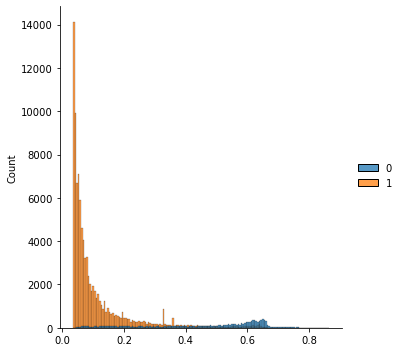

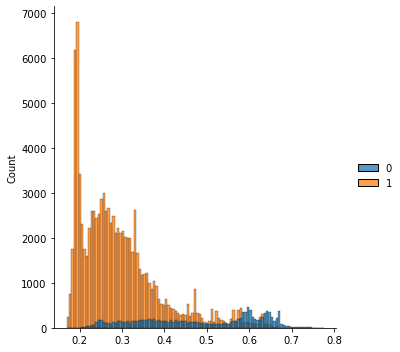

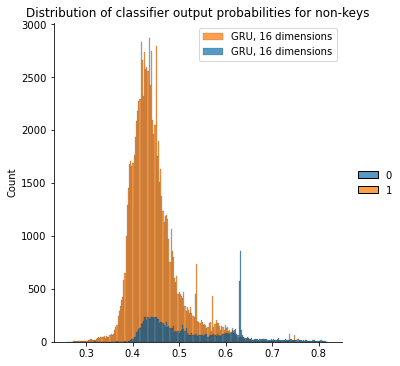

In [20]:
sns.displot(probs[0], label = "GRU, 128 dimensions")
sns.displot(probs[1], label = "GRU, 32 dimensions")
sns.displot(probs[2], label = "GRU, 16 dimensions")
plt.title("Distribution of classifier output probabilities for non-keys")
plt.legend()
plt.show()

In [21]:
def determine_tau(FPR_tau, prob_list):
  return np.percentile(np.array(prob_list),100*(1.-FPR_tau))

# LBF

In [22]:
# Costruisce classificatore per LBF e ritorna relativo numero di falsi negativi e tau ottimale
def build_LBF_classifier(model,FPR_tau):
  probs1, probs0 = get_classifier_probs(model)
  tau = determine_tau(FPR_tau,probs0)
  false_negs = []
  for i,url in enumerate(phishing_URLs):
    if(probs1[i] < tau):
      false_negs += [url]
  return false_negs, tau

In [23]:
def build_LBF_backup(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = (FPR-FPR_tau)/(1-FPR_tau)
  if(FPR_B <= 0):
    return "error"
  LBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    LBF_backup.add(url)
  return LBF_backup

In [24]:
def test_LBF(model, LBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    # Aggiunto if per evitare eccezioni da stack se la lista é vuota
    if(len([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))]) > 0):
        x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        x = x0.to(device)
        y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        y = y0.to(device)  
        total += len(y)

        start = time.time()
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
        for ix, p in enumerate(ps):
          if(p > tau):
            result = True        
          else:
            result = LBF_backup.check(testing_list[100*i+ix])
          if(result):
            fps += 1
        end = time.time()
        total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, LBF_backup.size / 8, (total_time)/len(y_test)

# SBF.py equivalent

In [25]:
def build_SLBF_initial(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B0 = FPR/FPR_tau*(1.-num_false_negs/len(phishing_URLs))
  if(FPR_B0 <= 0 or FPR_B0 >= 1):
    return "error"
  SLBF_initial = BloomFilter(len(phishing_URLs), FPR_B0)
  for url in phishing_URLs:
    SLBF_initial.add(url)
  return SLBF_initial

In [26]:
def build_SLBF_backup(false_negs, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = FPR_tau/((1-FPR_tau)*(len(phishing_URLs)/num_false_negs - 1))
  if(FPR_B <= 0):
    return "error"
  SLBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    SLBF_backup.add(url)
  return SLBF_backup

In [27]:
def test_SLBF(SLBF_initial, model, SLBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    # Aggiunto if per evitare eccezioni da stack se la lista é vuota
    if(len([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))]) > 0):
        x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        x = x0.to(device)
        y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        y = y0.to(device)  
        total += len(y)

        start = time.time()
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
        for ix, p in enumerate(ps):
          result = SLBF_initial.check(testing_list[100*i+ix])
          if(result):
            if(p>tau):
              result = True
            else:
              result = SLBF_backup.check(testing_list[100*i+ix])
          if(result):
            fps += 1
        end = time.time()
        total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, (SLBF_initial.size+SLBF_backup.size) / 8, (total_time)/len(y_test)

# $\tau$ analysis for LBF

In [28]:
fprs = [0.001,0.005,0.01,0.02]
fpr_ratios = [0.1*i for i in range(1,11)] # Ma fpr ratio 1.0 non ha senso?
false_negs = {}
taus = {}

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  false_negs[i] = {}
  taus[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      # Cambiata print
      print("Modello %d: %.3f, %.2f, %.20f, %.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0: 0.001, 0.10, 0.98427649632871028196, 0.7385250381
Modello 0: 0.001, 0.20, 0.96914633241860115298, 0.7014414651
Modello 0: 0.001, 0.30, 0.96195208781428465095, 0.6876611845
Modello 0: 0.001, 0.40, 0.95587035526218200321, 0.6792328613
Modello 0: 0.001, 0.50, 0.94786026848624194141, 0.6697654690
Modello 0: 0.001, 0.60, 0.93458429132982279164, 0.6623693988
Modello 0: 0.001, 0.70, 0.91923162500927091401, 0.6586702466
Modello 0: 0.001, 0.80, 0.91893495512868050845, 0.6585836428
Modello 0: 0.001, 0.90, 0.90640065267373726154, 0.6556924902
Modello 0: 0.001, 1.00, 0.88860045983831492666, 0.6523137124
Modello 0: 0.005, 0.10, 0.94786026848624194141, 0.6697654690
Modello 0: 0.005, 0.20, 0.88860045983831492666, 0.6523137124
Modello 0: 0.005, 0.30, 0.85841429948824443663, 0.6471886549
Modello 0: 0.005, 0.40, 0.83875991989913223357, 0.6434255736
Modello 0: 0.005, 0.50, 0.82741229696655049786, 0.6412742379
Modello 0: 0.005, 0.60, 0.82088555959356224179, 0.6398395115
Modello 0: 0.005, 0.70, 

In [29]:
# Salva risultati della cella precedente, ma poi li usa?
np.save(loc+"false_negs", false_negs)
np.save(loc+"taus", taus)

In [30]:
LBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  LBF_backups[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF_backups[i][(fpr,fpr_ratio)] = build_LBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
        if(LBF_backups[i][(fpr,fpr_ratio)] =='error'):
          print("bad epsilon")
          continue
        fpr0, BF_size, t = test_LBF(models[i], LBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
        print(fpr, fpr0, BF_size, t)
        LBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
        np.save(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), LBF)
      except:
        # Se il numero di falsi negativi é 0 sollevo eccezione e non salvo
        # Non controllata inizialmente probabilbente perché é stata esclusa la possibilitá di avere fn = 0 con dataset grandi
        print("Numero falsi negativi = 0")

0.001 0.0012743377621793265 24214.0 0.0001968804996215063
0.001 0.000741622796022395 24241.875 0.00019950933491086925
0.001 0.00105498454082059 24512.125 0.00019808381663893282
0.001 0.0009296398429013119 24873.75 0.00019575102472500544
0.001 0.00105498454082059 25271.125 0.0002039657496186718
0.001 0.0012221108047129605 25648.5 0.00019879601917599957
0.001 0.001002757583354224 26154.5 0.00019467550381150193
0.001 0.0010445391493273167 27452.75 0.00020358265517119966
0.001 0.0010863207153004094 29281.875 0.00020529610815627579
bad epsilon
0.005 0.004783989303919111 17965.375 0.00020459555808569622
0.005 0.004919779393331662 17207.875 0.00021260610208123252
0.005 0.004982451742291301 17023.875 0.00021636426533494784
0.005 0.004867552435865296 17086.125 0.00020701311739742024
0.005 0.0045332999080805545 17382.75 0.00020124988068990005
0.005 0.004773543912425838 17886.75 0.000210768767862359
0.005 0.0047422077379460185 18561.5 0.0002161610656447246
0.005 0.004898888610345116 19569.0 0.000

In [31]:
fnrs = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs[i] = pd.DataFrame(index=fpr_ratios, columns=fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      fnrs[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [32]:
true_fpr_LBF = {}
sizes_LBF = {}
times_LBF = {}
# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del LBF relativa
# Utile per i grafici successivi
for i in range(3):
  true_fpr_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        # Aggiunta except utile nel caso in cui il file non fosse stato salvato perché fn = 0
        print("error / numero falsi negativi 0")
        continue

0.0012743377621793265 34429.0 0.0001968804996215063
0.000741622796022395 34456.875 0.00019950933491086925
0.00105498454082059 34727.125 0.00019808381663893282
0.0009296398429013119 35088.75 0.00019575102472500544
0.00105498454082059 35486.125 0.0002039657496186718
0.0012221108047129605 35863.5 0.00019879601917599957
0.001002757583354224 36369.5 0.00019467550381150193
0.0010445391493273167 37667.75 0.00020358265517119966
0.0010863207153004094 39496.875 0.00020529610815627579
error / numero falsi negativi 0
0.004783989303919111 28180.375 0.00020459555808569622
0.004919779393331662 27422.875 0.00021260610208123252
0.004982451742291301 27238.875 0.00021636426533494784
0.004867552435865296 27301.125 0.00020701311739742024
0.0045332999080805545 27597.75 0.00020124988068990005
0.004773543912425838 28101.75 0.000210768767862359
0.0047422077379460185 28776.5 0.0002161610656447246
0.004898888610345116 29784.0 0.00020895776687294377
0.0048257708698922035 31571.5 0.00020507559537628575
error / num

In [33]:
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "trained_NN/plots/"

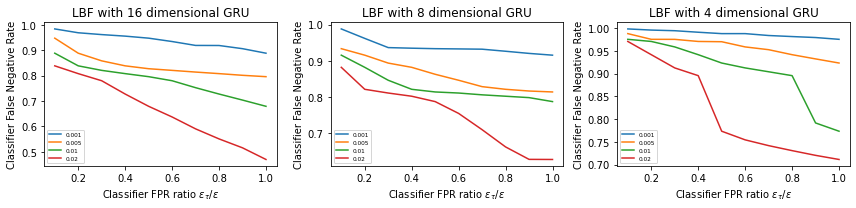

In [34]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_classifier_FNR.png")
# FPR_tau/FPR forced to stay between 0 and 1, 

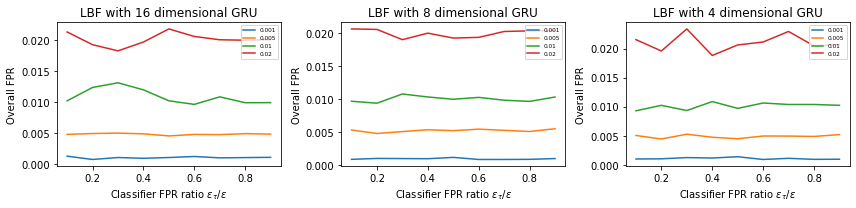

In [35]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper right')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_fpr.png")
#regardless of what the desired FPR is, the curve looks the same??

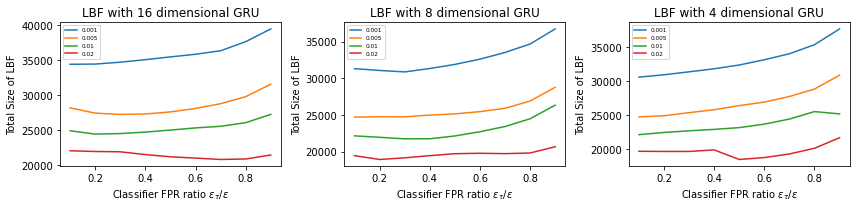

In [36]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Total Size of LBF")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper left')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_size.png")
# seems most optimal at 0.5

# $\tau$ analysis for SLBF

In [37]:
fpr_ratios2 = [1.*i for i in range(1,11)]

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  for fpr in fprs:
    for fpr_ratio in fpr_ratios2:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      print("Modello %d: %.3f, %.2f, %.20f, %.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0: 0.001, 1.00, 0.88860045983831492666, 0.6523137124
Modello 0: 0.001, 2.00, 0.83875991989913223357, 0.6434255736
Modello 0: 0.001, 3.00, 0.82088555959356224179, 0.6398395115
Modello 0: 0.001, 4.00, 0.80805458725802858932, 0.6369703021
Modello 0: 0.001, 5.00, 0.79603945709411849663, 0.6337306017
Modello 0: 0.001, 6.00, 0.78001928354223837303, 0.6295743940
Modello 0: 0.001, 7.00, 0.75265148705777651372, 0.6236402653
Modello 0: 0.001, 8.00, 0.72758288214788990889, 0.6187152882
Modello 0: 0.001, 9.00, 0.70377512423051247215, 0.6142882698
Modello 0: 0.001, 10.00, 0.67922569161165913254, 0.6087452805
Modello 0: 0.005, 1.00, 0.79603945709411849663, 0.6337306017
Modello 0: 0.005, 2.00, 0.67922569161165913254, 0.6087452805
Modello 0: 0.005, 3.00, 0.56975450567381147327, 0.5724982554
Modello 0: 0.005, 4.00, 0.46962842097456053425, 0.5272582245
Modello 0: 0.005, 5.00, 0.40717941111028704837, 0.4829563767
Modello 0: 0.005, 6.00, 0.36423644589483050726, 0.4496590275
Modello 0: 0.005, 7.00,

In [38]:
np.save(loc+"false_negs2", false_negs)
np.save(loc+"taus2", taus)

In [39]:
SLBF_initials = {}
SLBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup e quello iniziale costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  SLBF_initials[i] = {}
  SLBF_backups[i] = {}
  for fpr, fpr_ratio in false_negs[i].keys():
    c=(1.-len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs))
    # Se la tau non rispetta i bound
    if(fpr_ratio < c or fpr*fpr_ratio > c):
      print(fpr_ratio, fpr, "bad fpr_tau")
      continue
    # try:
    SLBF_initials[i][(fpr,fpr_ratio)] = build_SLBF_initial(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
    SLBF_backups[i][(fpr,fpr_ratio)] = build_SLBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr*fpr_ratio)
    if(SLBF_backups[i][(fpr,fpr_ratio)] =='error' or SLBF_initials[i][(fpr,fpr_ratio)]=='error'):
        continue
    fpr0, BF_size, t = test_SLBF(SLBF_initials[i][(fpr,fpr_ratio)], models[i], SLBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
    print(fpr, fpr0, BF_size, t)
    SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
    np.save(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)
    # except:
      # Eccezione aggiunta per fn =0
      # print("Numero di falsi negativi = 0")

# for fpr, fpr_ratio in false_negs2.keys():
#   c=(1.-len(false_negs2[(fpr,fpr_ratio)])/len(phishing_URLs))
#   if(fpr_ratio < c or fpr*fpr_ratio > c):
#     print(fpr_ratio, fpr, "bad fpr_tau")
#     continue
#   SLBF_keys += [(fpr,fpr_ratio)]
#   SLBF_initials[(fpr,fpr_ratio)] = build_SLBF_initial(false_negs2[(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
#   SLBF_backups[(fpr,fpr_ratio)] = build_SLBF_backup(false_negs2[(fpr,fpr_ratio)], fpr*fpr_ratio)
#   if(SLBF_backups[(fpr,fpr_ratio)] =='error' or SLBF_initials[(fpr,fpr_ratio)]=='error'):
#     continue
#   fpr0, BF_size, t = test_SLBF(SLBF_initials[(fpr,fpr_ratio)], models[2], SLBF_backups[(fpr,fpr_ratio)], taus[(fpr,fpr_ratio)])
#   print(fpr, fpr0, BF_size, t)
#   SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[2], "time": t}
#   np.save(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)

0.001 0.0008042951449820339 24007.0 0.0003120293690565187
0.001 0.0008565221024483998 23792.0 0.000266604027752491
0.001 0.0015041363750313362 23715.0 0.00029348335917993946
0.001 0.0008878582769282192 23653.375 0.0002673874973623219
0.001 0.0008983036684214925 23557.875 0.000307775857684267
0.001 0.0008669674939416729 23374.75 0.0003663880654501817
0.001 0.0009714214088744046 23155.5 0.00027192083727579285
0.001 0.0010758753238071363 23188.125 0.0004344044611688504
0.001 0.0008565221024483998 23016.25 0.0003250312603953449
0.001 0.0038230132865379796 22754.75 0.0002471197041949603
0.005 0.009672432522770953 17912.125 0.00025381416448467387
0.005 0.011030333416896465 17109.0 0.0002474526325204154
0.005 0.005431603576502048 16782.375 0.00024460282373161375
0.005 0.004951115567811482 16614.375 0.00023971163181570466
0.005 0.006914849168546837 16564.625 0.00024197977856505113
0.005 0.0079802791008607 16576.0 0.00024294252780940765
0.005 0.00547338514247514 16574.25 0.00024016116698841967


0.01 0.021256371688810897 13393.5 0.0001678460745262783
0.02 0.02054608506726832 10863.125 0.0001665696400871669
0.02 0.022426255536057493 10964.625 0.0001675514581359458
0.02 0.01860324224951951 11061.375 0.00016879874771177455
0.02 0.020598312024734687 10962.0 0.0001674430097584897
0.02 0.01707821509150163 10923.875 0.0001668425005580226
0.02 0.020076042450071028 10874.375 0.00016725918518886279
0.02 0.02126681708030417 10960.75 0.00016783662853239373
0.02 0.02172641430600819 10976.625 0.00016859904201823467
0.02 0.01877036851341188 11045.25 0.00016743847976564077
0.001 0.0008042951449820339 24219.375 0.00012737392054331715
0.001 0.0008774128854349461 24199.5 0.0001285443222691085
0.001 0.0009087490599147656 24191.375 0.00012737836835377794
0.001 0.0013996824600986046 24162.75 0.00012856202634781277
0.001 0.0014414640260716973 24136.75 0.00012959087015523182
0.001 0.0009609760173811315 24144.25 0.00012884100816139672
0.001 0.0011907746302331412 24106.375 0.00012780921823988186
0.001 

In [40]:
fnrs2 = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs2[i] = pd.DataFrame(index=fpr_ratios+fpr_ratios2, columns=fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
      fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)
  # for fpr,fpr_ratio in false_negs2.keys():
      # fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs2[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [42]:
true_fpr_SLBF = {}
sizes_SLBF = {}
times_SLBF = {}

# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del SLBF relativo
# Utile per i grafici successivi
for i in range(3):
  true_fpr_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  sizes_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  times_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
    try:
      SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
      true_fpr_SLBF[i].loc[fpr_ratio,fpr] = SLBF['FPR']
      sizes_SLBF[i].loc[fpr_ratio,fpr] = SLBF['size']
      times_SLBF[i].loc[fpr_ratio,fpr] = SLBF['time']
      print(SLBF['FPR'], SLBF['size'], SLBF['time'])
    except:
      print("error", fpr_ratio, fpr) # Bad tau + false negs = 0
      continue

# for fpr,fpr_ratio in false_negs2.keys():
#   try:
#     SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
#     true_fpr_SLBF.loc[fpr_ratio,fpr] = SLBF['FPR']
#     sizes_SLBF.loc[fpr_ratio,fpr] = SLBF['size']
#     times_SLBF.loc[fpr_ratio,fpr] = SLBF['time']
#     print(SLBF['FPR'], SLBF['size'], SLBF['time'])
#   except:
#     print("error")
#     continue

0.0008042951449820339 34222.0 0.0003120293690565187
0.0008565221024483998 34007.0 0.000266604027752491
0.0015041363750313362 33930.0 0.00029348335917993946
0.0008878582769282192 33868.375 0.0002673874973623219
0.0008983036684214925 33772.875 0.000307775857684267
0.0008669674939416729 33589.75 0.0003663880654501817
0.0009714214088744046 33370.5 0.00027192083727579285
0.0010758753238071363 33403.125 0.0004344044611688504
0.0008565221024483998 33231.25 0.0003250312603953449
0.0038230132865379796 32969.75 0.0002471197041949603
0.009672432522770953 28127.125 0.00025381416448467387
0.011030333416896465 27324.0 0.0002474526325204154
0.005431603576502048 26997.375 0.00024460282373161375
0.004951115567811482 26829.375 0.00023971163181570466
0.006914849168546837 26779.625 0.00024197977856505113
0.0079802791008607 26791.0 0.00024294252780940765
0.00547338514247514 26789.25 0.00024016116698841967
0.005953873151165706 26787.125 0.00024084109675070393
0.004804880086905657 26772.75 0.0002400797815204

0.0010967661067936827 30127.75 0.00013078002440777
0.0010236483663407705 30091.75 0.0001384879354945677
0.004303501295228545 24546.125 0.00013430414467195805
0.004783989303919111 24446.0 0.0001463394092519331
0.00504512409125094 24478.5 0.0001520311323395247
0.005849419236232974 24459.375 0.0001510060938257138
0.004658644605999833 24475.375 0.0001504628134518924
0.004961560959304755 24392.5 0.00015047143264114484
0.005222695746636584 24358.125 0.00014565921301948125
0.005536057491434779 24277.25 0.00014036036159317426
0.005442048967995321 24212.0 0.00014448687129125487
0.005744965321300242 24148.375 0.00014080274938849704
0.009839558786663325 22014.5 0.0001436726928623914
0.011521266817080305 22027.875 0.0001466914138529368
0.009996239659062421 21961.0 0.00014359018672545611
0.014028160775465865 21845.875 0.00014610244256168855
0.013464109634829113 21717.0 0.00014426962837416237
0.010340937578340436 21661.125 0.0001429831577221971
0.011155678114815742 21626.25 0.00013836036850518128
0.

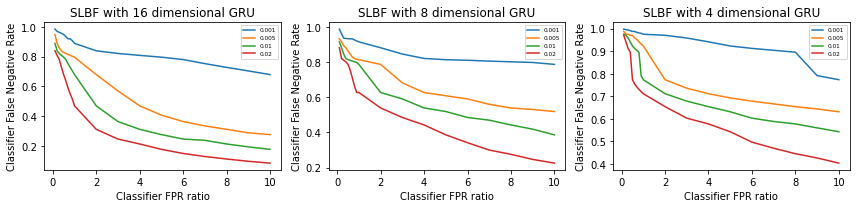

In [43]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs2[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_classifier_FNR.png")

# FPR_tau/FPR forced to stay between 0 and 1, 

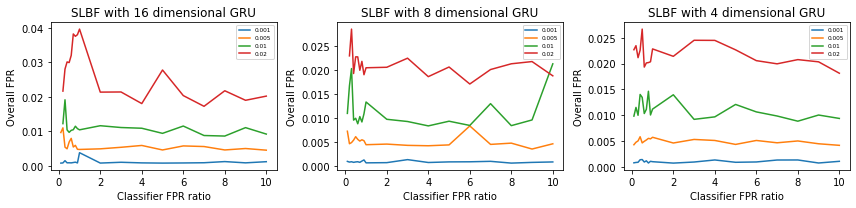

In [44]:
f,ax=plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_fpr.png")


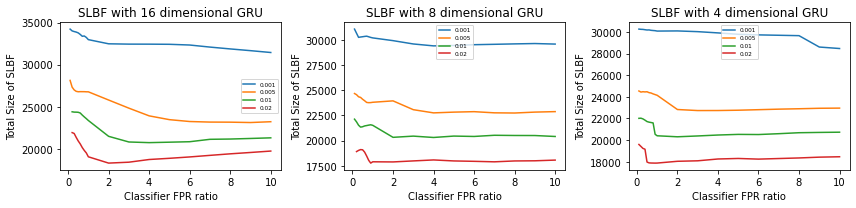

In [45]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Total Size of SLBF")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_size.png")


#size is best when ratio = 1

In [90]:
true_fpr_LBF_LH = {}
sizes_LBF_LH = {}
times_LBF_LH = {}
for i in range(3):
  true_fpr_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_LH_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        print("error")
        continue


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


In [47]:
# Grafici attualmente non funzionanti, da sistemare

x_BF = []
y_BF = []
for b in BF_sizes.keys():
  x_BF += [b]
  y_BF += [BF_sizes[b]]

ValueError: x and y must have same first dimension, but have shapes (4,) and (80,)

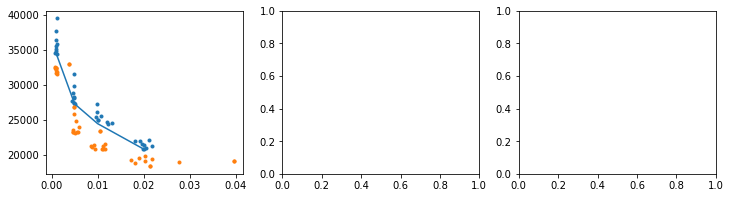

In [48]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  x_LBF = []
  y_LBF = []
  z_LBF = []
  x_SLBF = []
  y_SLBF = []
  z_SLBF = []
  for j1 in range(true_fpr_LBF[i].shape[1]):
    for j0 in range(true_fpr_LBF[i].shape[0]):
      x_LBF += [true_fpr_LBF[i].iloc[j0,j1]]
      y_LBF += [sizes_LBF[i].iloc[j0,j1]]
    z_LBF += [min(sizes_LBF[i].iloc[:,j1])]
  
  for j1 in range(true_fpr_SLBF[i].shape[1]):
    for j0 in range(true_fpr_SLBF[i].shape[0]):
      if sizes_SLBF[i].dropna().iloc[:,j1].size != 0:
        if(true_fpr_SLBF[i].index[j0] >= 1.):
          x_SLBF += [true_fpr_SLBF[i].iloc[j0,j1]]
          y_SLBF += [sizes_SLBF[i].iloc[j0,j1]]
        z_SLBF += [min(sizes_SLBF[i].dropna().iloc[:,j1])]
        
  ax[i].scatter(x_LBF,y_LBF, label = 'LBF', marker='.')
  ax[i].scatter(x_SLBF,y_SLBF, label = 'SLBF', marker='.')
  ax[i].plot(true_fpr_LBF[i].columns,z_LBF)
  ax[i].plot(true_fpr_SLBF[i].columns,z_SLBF)
  ax[i].set_title(str(h_sizes[i])+" dimensional GRU")
  ax[i].set_xlabel("Observed FPR")
  ax[i].set_ylabel("Total Size (bytes)")
  ax[i].set_xlim(left=0, right=0.03)
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"comparison_size_min.png")